<a href="https://colab.research.google.com/github/AslanDevbrat/NLP/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Processing

In [1]:
!git clone https://github.com/Neuralearn/deep-learning-with-tensorflow-2

Cloning into 'deep-learning-with-tensorflow-2'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 28 (delta 16), reused 28 (delta 16), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2022-07-18 11:07:31--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.4MB/s    in 4.9s    

2022-07-18 11:07:36 (16.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
!tar -xzf /content/aclImdb_v1.tar.gz

In [37]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Reshape, Embedding,GRU
import numpy as np
import re
import string
import nltk
import numpy as np
from matplotlib import pyplot as plt
import pandas
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
train_directory = "/content/aclImdb/train"
val_directory = "/content/aclImdb/test"

In [12]:
!mv /content/aclImdb/train/unsup /content

mv: cannot stat '/content/aclImdb/train/unsup': No such file or directory


In [13]:
train_dataset = text_dataset_from_directory(
    train_directory,
)

Found 25000 files belonging to 2 classes.


In [14]:
val_dataset = text_dataset_from_directory(
    val_directory,
    shuffle = True
)

Found 25000 files belonging to 2 classes.


In [9]:
for x, y in train_dataset.take(1):
  print(x)
  print()
  print(y)

tf.Tensor(
[b'The horse is indeed a fine animal. Picturesque depictions of wild horses and their grace could never have been more majestic in an animation flick.<br /><br />The animation is simply stupendous. The fine animation forms the backbone of the beauty that the horses embolden across the flick. More so when the stallion traverses diverse terrain, jumps across cliffs and braves waters. <br /><br />Soundtrack too is very impressive. The wonderful instrumental music lures you to appreciate the movie. <br /><br />"They say the story of the west was written from the saddle of a horse . " huh? Well ,The story of a fine horse sure was written from the saddle of the west .<br /><br />All in all, this movie is clearly up there with the best .It is one of the best animation flicks i have watched. Would be a very fine choice on a lonely night. An easy 9/10.'
 b'I am completely baffled as to why this film is even liked, let alone held in such high regard, especially by so many critics who 

In [15]:
def preprocess_sentences(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    output=tf.strings.lower(input_data)
    outputs=tf.strings.regex_replace(output,"<[^>]+>","")
    outputs=tf.strings.regex_replace(output,"<[%s]"%re.escape(string.punctuation)," ")
    outputs=tf.strings.regex_replace(output,"  "," ")
    
    return output

In [16]:
# def preprocess_sentences(input_data):

#      output = tf.strings.lower(input_data)
#      output = tf.strings.regex_replace(output, "<[^>]+>","")
#      output = tf.strings.regex_replace(output,'[%s]' %re.escape(string.punctuation), "  ")
#      output = tf.strings.regex_replace(output, '  '," "  )
#      lemmatizer = nltk.stem.WordNetLemmatizer()
#      output = tf.strings.join([lemmatizer.lemmatize(str(word)[12:-26], pos = "a") for word in tf.strings.split(output)], separator = " ")
#      return output
# preprocess_sentences("I kind of consider myself as the #1 fan of Hidden Frontier")


In [17]:
VOCAB_SIZE=2000
SEQUENCE_LENGTH=100
vectorize_layer=TextVectorization(
    standardize=preprocess_sentences,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
)
training_data=train_dataset.map(lambda x,y:x)### inputsxandyand outputsx
vectorize_layer.adapt(training_data)### Adapt the vectorize Layer to the training data

In [18]:
def vectorizer(review, label):
  return tf.one_hot(vectorize_layer(review), depth = VOCAB_SIZE), label


In [19]:
train_dataset = train_dataset.map(vectorizer)
val_dataset = val_dataset.map(vectorizer)

In [18]:
for x , y in train_dataset.take(1):
  print(y)

tf.Tensor([0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0], shape=(32,), dtype=int32)


## Modeling


In [19]:
class RNNCell(tf.keras.layers.Layer):
  def __init__(self, units = 4, hidden_size = 7,):
    super(RNNCell, self).__init__()

    self.units = units
    self.hidden_size = hidden_size

  def build(self, input_shape):
    print(input_shape)

    self.w_hh = self.add_weight(
        shape = (self.hidden_size, self.hidden_size),
        initializer = "random_normal",
        trainable = True,
    )
    self.w_hx = self.add_weight(
        shape = (input_shape[-1], self.hidden_size),
        initializer = "random_normal",
        trainable = True,
    )
    self.w_yh = self.add_weight(
        shape = (self.hidden_size, self.units),
        initializer = "random_normal",
        trainable = True,
    )

    self.b_h = self.add_weight(
        shape = (self.hidden_size,),
        initializer = "random_normal",
        trainable = True,
    )
    
    self.b_y = self.add_weight(
        shape = (self.units,),
        initializer = "random_normal",
        trainable = True,
    )

  def call(self, inputs, h_prev = None):
    if(h_prev == None):
      h_prev = tf.zeros([inputs.shape[0], self.hidden_size])
    h = tf.nn.tanh(tf.matmul(h_prev, self.w_hh) + tf.matmul(inputs, self.w_hx) + self.b_h)
    y = tf.nn.tanh(tf.matmul(h, self.w_yh) + self.b_y)
    
    return tf.constant(h), tf.constant(y)


In [20]:
input = tf.zeros([8,  2000])
layer = RNNCell()
h,y = layer(input)
h.shape, y.shape

(8, 2000)


(TensorShape([8, 7]), TensorShape([8, 4]))

In [21]:
class RNN(tf.keras.layers.Layer):
  def __init__(self, units, ):
    super(RNN, self).__init__()
    self.rnn = RNNCell(units)

  def call(self, inputs):
    output = []

    h,y = self.rnn(input[:,0,:])
    output.append(y)

    for i in range(1, input.shape[-2]):
      h, y = self.rnn(input[:,i,:], h)
      output.append(y)
    shape = np.array(output).shape
    return tf.reshape(output,[ shape[1], shape[0], shape[2]])


In [22]:
input = tf.zeros([8, 100,2000])
layer = RNN(4)
output = layer(input)
output.shape

(8, 2000)


TensorShape([8, 100, 4])

In [23]:
input = tf.zeros([8, 100,2000])
layer = SimpleRNN(4, activation = 'tanh', use_bias = True, return_sequences=False, name = "layer1")

output = layer(input)
output.shape

TensorShape([8, 4])

In [53]:
 input = tf.keras.layers.Input(shape = (SEQUENCE_LENGTH,))
 embedding_size = 256

 model = tf.keras.models.Sequential([
                                     input,
                                     tf.keras.layers.Embedding(VOCAB_SIZE, embedding_size),
                                     SimpleRNN(4, activation = 'tanh', use_bias = True, return_sequences=True, name = "layer1"),
                                     Dense(1, activation = "relu", name="layer2"),
                                     Reshape((SEQUENCE_LENGTH,), name = "layer3"),
                                     Dense(1, activation = "sigmoid", name = "layer4")
 ])
 model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 256)          512000    
                                                                 
 layer1 (SimpleRNN)          (None, 100, 4)            1044      
                                                                 
 layer2 (Dense)              (None, 100, 1)            5         
                                                                 
 layer3 (Reshape)            (None, 100)               0         
                                                                 
 layer4 (Dense)              (None, 1)                 101       
                                                                 
Total params: 513,150
Trainable params: 513,150
Non-trainable params: 0
_________________________________________________________________


# Training and Validation and Testing

In [42]:
LR = 1e-4
EPOCH = 50

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(lr = LR,),
    metrics = ["accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
checkpoint_filepath  = "basic_rnn.hdf5"

#checkpoint_filepath="imdb/basic_rnn.hdf5"
callback=tf.keras.callbacks.ModelCheckpoint(
   filepath=checkpoint_filepath,### WHERE BEST WEIGHTS ARE STORED
    save_weights_only=True,
   monitor="loss",
   mode='min',
    save_best_only=True)
#Train model on dataset
history=model.fit(train_dataset,validation_data=val_dataset,verbose=1,epochs=EPOCH,callbacks=[callback])#

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 79s 100ms/step - loss: 0.6943 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4972
Epoch 2/50
782/782 [==============================] - 78s 99ms/step - loss: 0.6929 - accuracy: 0.5111 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 3/50
782/782 [==============================] - 79s 101ms/step - loss: 0.6920 - accuracy: 0.5238 - val_loss: 0.6929 - val_accuracy: 0.5062
Epoch 4/50
782/782 [==============================] - 78s 100ms/step - loss: 0.6907 - accuracy: 0.5358 - val_loss: 0.6926 - val_accuracy: 0.5113
Epoch 5/50
782/782 [==============================] - 78s 99ms/step - loss: 0.6849 - accuracy: 0.5412 - val_loss: 0.6812 - val_accuracy: 0.5510
Epoch 6/50
782/782 [==============================] - 79s 101ms/step - loss: 0.6501 - accuracy: 0.6271 - val_loss: 0.6419 - val_accuracy: 0.6544
Epoch 7/50
782/782 [==============================] - 78s 99ms/step - loss: 0.6094 - accuracy: 0.7084 - val_loss: 0.6176 - val_accuracy: 0.7038

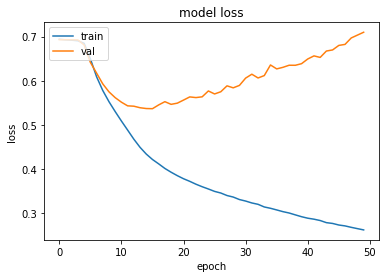

In [44]:
plt.plot(history.history["loss"][:])
plt.plot(history.history["val_loss"][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

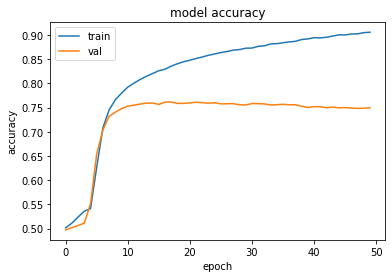

In [45]:
plt.plot(history.history["accuracy"][:])
plt.plot(history.history["val_accuracy"][:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

In [48]:
test_data = tf.data.Dataset.from_tensor_slices([["i love it"],["i dont like movie"]
])

In [49]:
def vectorizer_test(review):
    return tf.one_hot(vectorize_layer(review),depth=VOCAB_SIZE)

test_dataset=test_data.map(vectorizer_test)
model.predict(test_dataset)

array([[0.9695122],
       [0.7549498]], dtype=float32)

#Embedding

In [23]:
input = tf.zeros([2000])
layer = Embedding(2, 100)

output = layer(input)
print(output[0].shape)
print(output[1].shape)
print(output[2].shape)
print(output.shape)

(100,)
(100,)
(100,)
(2000, 100)


## LSTM

In [59]:
input = tf.zeros([8, 100,2000])
layer = LSTM(4, activation = 'tanh', use_bias = True, return_sequences=True, return_state = True)

output = layer(input)
print(output[0].shape)
print(output[1].shape)
print(output[2].shape)
print(len(output))

(8, 100, 4)
(8, 4)
(8, 4)
3


In [39]:
 input = tf.keras.layers.Input(shape = (SEQUENCE_LENGTH,VOCAB_SIZE))
 embedding_size = 256

 model = tf.keras.models.Sequential([
                                     input,
                                  
                                     LSTM(4, activation = 'tanh', use_bias = True, return_sequences=True, name = "layer1"),
                                     Dense(1, activation = "relu", name="layer2"),
                                     Reshape((SEQUENCE_LENGTH,), name = "layer3"),
                                     Dense(1, activation = "sigmoid", name = "layer4")
 ])
 model.summary()

LR = 1e-4
EPOCH = 50

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(lr = LR,),
    metrics = ["accuracy"],
)
checkpoint_filepath  = "basic_rnn.hdf5"

#checkpoint_filepath="imdb/basic_rnn.hdf5"
callback=tf.keras.callbacks.ModelCheckpoint(
   filepath=checkpoint_filepath,### WHERE BEST WEIGHTS ARE STORED
    save_weights_only=True,
   monitor="loss",
   mode='min',
    save_best_only=True)
#Train model on dataset
history=model.fit(train_dataset,validation_data=val_dataset,verbose=1,epochs=EPOCH,callbacks=[callback])#

plt.plot(history.history["loss"][:])
plt.plot(history.history["val_loss"][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

plt.plot(history.history["accuracy"][:])
plt.plot(history.history["val_accuracy"][:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 100, 4)            32080     
                                                                 
 layer2 (Dense)              (None, 100, 1)            5         
                                                                 
 layer3 (Reshape)            (None, 100)               0         
                                                                 
 layer4 (Dense)              (None, 1)                 101       
                                                                 
Total params: 32,186
Trainable params: 32,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 107s 135ms/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6926 - val_accuracy: 0.5093
Epoch 2/50
782/782 [==============================] - 103s 132ms/step - loss: 0.6905 - accuracy: 0.5052 - val_loss: 0.6872 - val_accuracy: 0.5023
Epoch 3/50
782/782 [==============================] - 102s 130ms/step - loss: 0.6473 - accuracy: 0.5895 - val_loss: 0.6075 - val_accuracy: 0.7064
Epoch 4/50
782/782 [==============================] - 102s 130ms/step - loss: 0.5826 - accuracy: 0.7404 - val_loss: 0.5849 - val_accuracy: 0.7528
Epoch 5/50
782/782 [==============================] - 101s 129ms/step - loss: 0.5572 - accuracy: 0.7696 - val_loss: 0.5723 - val_accuracy: 0.7625
Epoch 6/50
782/782 [==============================] - 101s 129ms/step - loss: 0.5381 - accuracy: 0.7834 - val_loss: 0.5596 - val_accuracy: 0.7717
Epoch 7/50
782/782 [==============================] - 102s 131ms/step - loss: 0.5226 - accuracy: 0.7918 - val_loss: 0.5517 - val_accura

KeyboardInterrupt: ignored

# GRU

In [ ]:
inputs=tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,VOCAB_SIZE),)
EMBEDDING_DIM=100
embedding=tf.keras.layers.Embedding(VOCAB_SIZE,EMBEDDING_DIM)
model=  tf.keras.models.Sequential([
    inputs,
    
    tf.keras.layers.GRU(20,activation='tanh',use_bias=True,return_sequences=True),
    tf.keras.layers.Dense(1,activation='relu'),
    tf.keras.layers.Reshape((SEQUENCE_LENGTH,)),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
model.summary()

LR=5e-4
EPOCH=15
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=LR,),
    metrics=['accuracy']
)
checkpoint_filepath  = "basic_rnn.hdf5"

callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    save_best_only=True)
#Train model on dataset
history = model.fit(train_dataset,validation_data=val_dataset,verbose=1,epochs=EPOCH,callbacks=[callback])
plt.plot(history.history["loss"][:])
plt.plot(history.history["val_loss"][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

plt.plot(history.history["accuracy"][:])
plt.plot(history.history["val_accuracy"][:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 100, 20)           121320    
                                                                 
 dense_6 (Dense)             (None, 100, 1)            21        
                                                                 
 reshape_3 (Reshape)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,442
Trainable params: 121,442
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
